# Implementation details and choises

## Mapping time to position in turbulence field

When requestion turbulence at a point $(x,y,z,t)$ in the wind farm, this point is be mapped to the corresponding turbulence field coordinate $(x_t,y_t,z_T)$ utilizing Taylor's frozen turbulence hypothesis

Typically this is done by $(x_t,y_t,z_t) = (x+U\cdot t,y,z)$ where U is the turbulence field transport speed.

Moreover, the turbulence field may have an additional offset:

In [1]:
def get_turbulence_point(x,y,z,t):
    xyz_t = np.array([x + turb_field_speed*t,y,z]) + turb_field_offset

This method, however, is problematic if the turbulence field transport speed changes, as a fixed point in the wind farm will jump $dU t$ in the turbulence field.

To overcome this, $U \cdot t$ is changed to $\int_t{U(t) dt}$. In Dynamiks this is implemented by updating the offset in each time step to include the turbulence advection:

In [2]:
t_last = 0
offset = (2500, 100, 20) # offset in x,y,z
def get_turbulence_point(x,y,z,t):
    if t>t_last:
        offset[0] += (t-t_last)*U
        t_last = t
    return np.array([x,y,z]) + offset

## Deficit interpolation

The deficit profiles are defined in the (y-z) plane and advection along the x-axis. This results in questionable profile shape if distance between particles in the (y-z) plane is large compared to the distance in along the x-axis.

Possible solutions
- Define the deficit profile perpendicular to the actual particle direction.
  - if the wake deficit rotates, then it should also change u deficit to v deficit. Does this make sense?
- Accept the narrow shape as it is a consequence of the meandering formulation


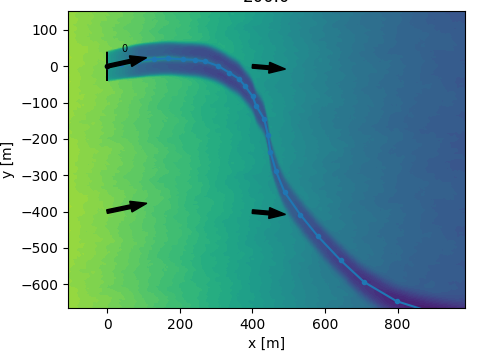

## Overtaken particles

When a particle overtake another particle, the downstream positions, $x$, of the particles are not monotonically increasing. This results in wrong interpolation and Dynamiks are not able to interpolate the particle path using pchip

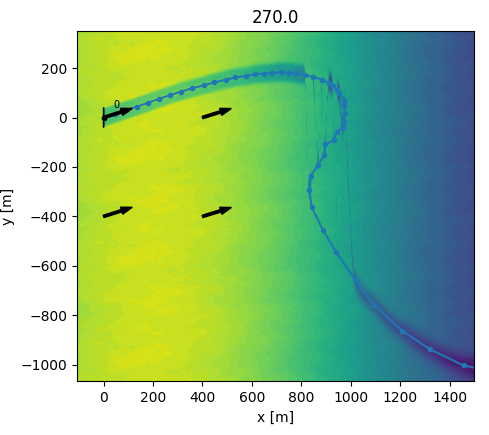

Current solution is to disregard particles that have been overtaken

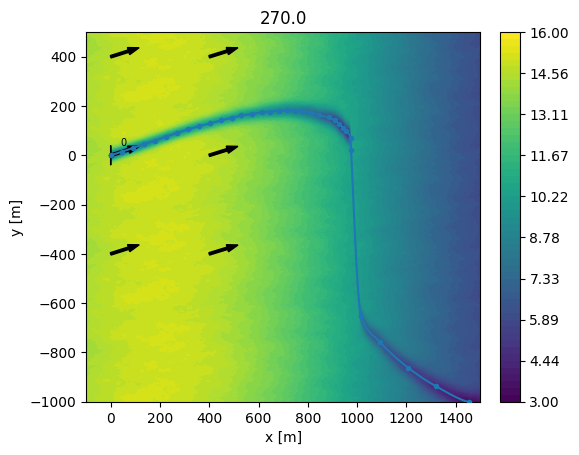

In [3]:
from numpy import newaxis as na
from dynamiks.dwm.particle_motion_models import ParticleMotionModel, XSpeed
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation, DemoSite
from dynamiks.visualizers import ParticleVisualizer
import numpy as np
from dynamiks.views import XYView
from dynamiks.visualizers._visualizers import WindDirectionVisualizer
import matplotlib.pyplot as plt


site = DemoSite(ws=10, ti=0.01)
site.turbulenceField.uvw[:2, ] += np.cos(np.linspace(0, 2 * np.pi, 1024)[:, na, na]) * 5  # add sinusodial to u and v
fs = DefaultDWMFlowSimulation(
    site=site,
    particleMotionModel=ParticleMotionModel(x_speed=XSpeed.Rotor),
    d_particle=.5,
    n_particles=100)
wd_x, wd_y = [v.flatten() for v in np.meshgrid([-400, 0, 400], [-400, 0, 400])]

fs.run(270)
view = XYView(z=70, x=np.linspace(-100, 1500, 500), y=np.linspace(-1000, 500, 500),
                     adaptive=True,
                     visualizers=[WindDirectionVisualizer(wd_x, wd_y, 70, 5),
                                  ParticleVisualizer(deficit_profile=False)])
fs.show(view=view)

This solution has the issue that the wake jumps when a particle is overtaken

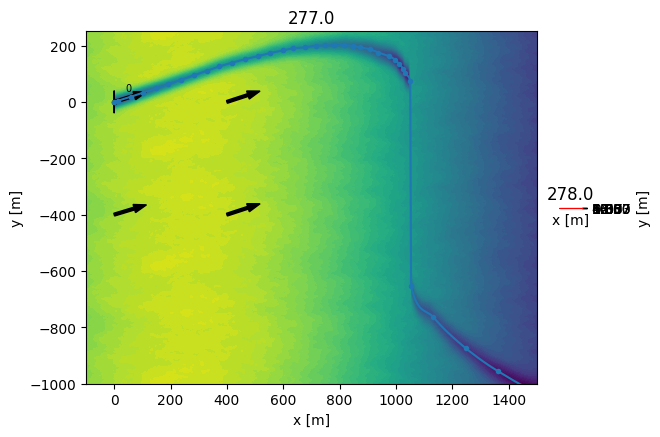

In [4]:

fs.run(277)
fs.show(view=XYView(z=70, x=np.linspace(-100, 1500, 500), y=np.linspace(-1000, 250, 500),
                    visualizers=[WindDirectionVisualizer(wd_x, wd_y, 70, 5),
                                 ParticleVisualizer(deficit_profile=False)]))
fs.step()
fs.show(view=XYView(z=70, x=np.linspace(-100, 1500, 500), y=np.linspace(-1000, 250, 500),
                    flowVisualizer=False,
                    visualizers=[ParticleVisualizer(deficit_profile=False, color='r')], clear=False))

## Linear or pchip particle path

In [5]:
from dynamiks.utils.test_utils import DefaultDWMFlowSimulation, tfp
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate._cubic import pchip_interpolate
from dynamiks.sites.turbulence_fields import MannTurbulenceField
from dynamiks.sites._site import TurbulenceFieldSite
from py_wake.utils.plotting import setup_plot
U = 10
turbfield = MannTurbulenceField.from_netcdf(
    tfp + "mann_turb/Hipersim_mann_l29.4_ae1.0000_g3.9_h0_1024x128x32_9.600x9.60x9.60_s0001.nc",
)
turbfield.scale_TI(TI=.1, U=U)
site = TurbulenceFieldSite(ws=U, turbulenceField=turbfield, turbulence_offset=(-2500, -100, 20))


def get_pxyz(d_particle):
    n_particles = int(1000 / (d_particle * 80)) + 2
    dt = d_particle / U

    fs = DefaultDWMFlowSimulation(x=[0], y=[0], site=site, d_particle=d_particle, n_particles=n_particles, dt=dt)
    fs.run(100, verbose=1)
    # fs.show(XYView(visualizers=[ParticleVisualizer()]))
    x = np.linspace(0, 1000, n_particles * 2)
    return fs.particle_position_xip[:, 0, fs.get_active_particles_idx(0, x)]

In [6]:
d_particle_fine = 0.05
pxyz_fine = get_pxyz(.05)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

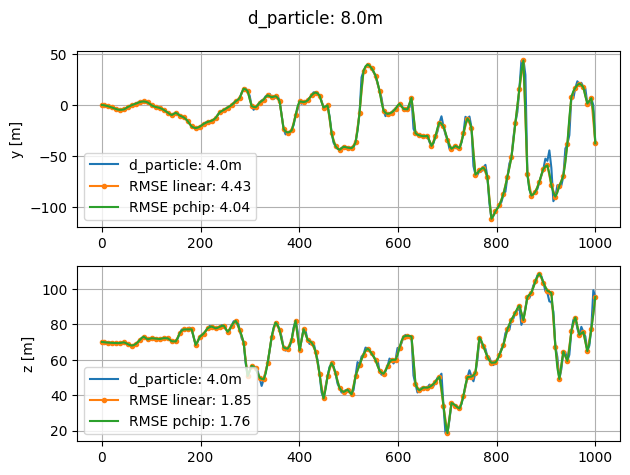

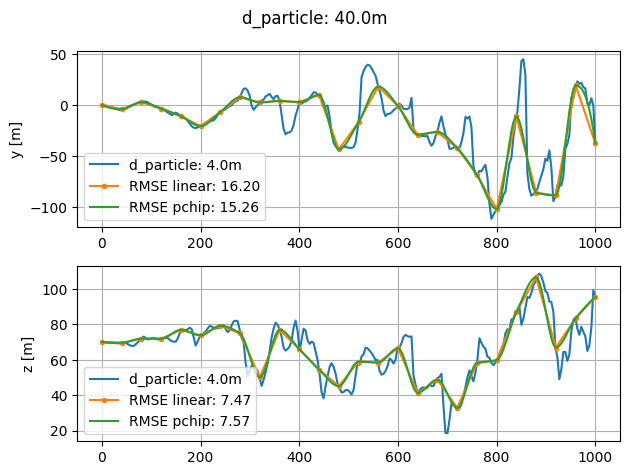

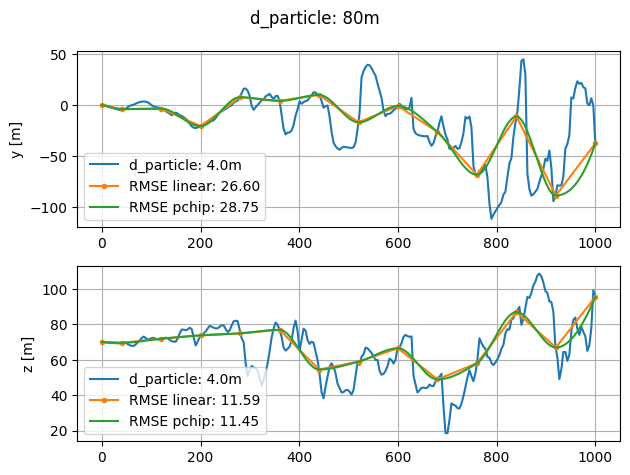

In [7]:
for d_p in [.1, .5, 1]:
    fig, axes = plt.subplots(2, 1)
    fig.suptitle(f"d_particle: {d_p*80}m")
    axes[0].plot(pxyz_fine[0], pxyz_fine[1], label=f'd_particle: {d_particle_fine*80}m')
    axes[1].plot(pxyz_fine[0], pxyz_fine[2], label=f'd_particle: {d_particle_fine*80}m')
    pxyz = get_pxyz(d_p)

    def rmse(err):
        return np.sqrt(np.mean(err**2))

    def linear_RMSE(i):
        return rmse(pxyz_fine[i] - np.interp(pxyz_fine[0], pxyz[0], pxyz[i]))

    def pchip_RMSE(i):
        return rmse(pxyz_fine[i] - pchip_interpolate(pxyz[0], pxyz[i], pxyz_fine[0]))

    axes[0].plot(pxyz[0], pxyz[1], '.-', label=f'RMSE linear: {linear_RMSE(1):.2f}')
    axes[1].plot(pxyz[0], pxyz[2], '.-', label=f'RMSE linear: {linear_RMSE(2):.2f}')

    
    axes[0].plot(pxyz_fine[0], pchip_interpolate(pxyz[0], pxyz[1], pxyz_fine[0]), '-',
                 label=f'RMSE pchip: {pchip_RMSE(1):.2f}')
    axes[1].plot(pxyz_fine[0], pchip_interpolate(pxyz[0], pxyz[2], pxyz_fine[0]), '-',
                 label=f'RMSE pchip: {pchip_RMSE(2):.2f}')
    setup_plot(ax=axes[0], ylabel='y [m]')
    setup_plot(ax=axes[1], ylabel='z [m]')
    plt.savefig(f'pchip {d_p}.png')
plt.show()